In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 25 10:40:42 2020
Modified on Fri Nov 05 10:40:42 2021

@author: mwall
@author-modified: sturkarslan
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('.')

#import miner as miner
import miner_py3_kk as miner
from tqdm.notebook import tqdm, trange
import time
import collections
from itertools import chain
from importlib import reload

# Path to the miner directory
input_path = "/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020"
data_path = "/Volumes/omics4tb2/SYGNAL/GBM-Serdar/data/"
print("Current working directory: " + input_path)

Current working directory: /Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_MicroLowessRNATMM.08.24.2020


### Load Expression data for the cohort

In [13]:
expressionData = pd.read_csv(data_path + "GbmMicroRNAMergedWithIDsZScored.csv", sep=",", index_col=0, header = 0)
expressionData.head()

,TCGA-14-1034.1,TCGA-06-0190.1,TCGA-19-4065.1,TCGA-06-0125.1,TCGA-02-0055,TCGA-06-0210.1,TCGA-06-AABW,TCGA-19-4065,TCGA-06-0211.1,TCGA-28-2499,...,TCGA-02-0456,TCGA-02-0269,TCGA-06-0397,TCGA-02-0043,TCGA-06-0413,TCGA-28-6450,TCGA-19-2623,TCGA-02-0079,TCGA-02-0281,TCGA-08-0349
ENSG00000283681,0.365340,0.859456,0.691551,0.804120,-0.063949,0.783231,1.287966,-0.145116,0.221032,-1.095594,...,0.148827,0.774041,-1.702493,-0.070572,1.447313,0.745617,0.982889,0.005778,1.400442,-1.002587
ENSG00000283630,-1.009928,-0.351957,-0.027208,-1.068849,1.158995,-0.617657,0.200077,0.562189,0.963349,0.472726,...,-0.880169,-0.508012,-0.109192,0.094321,0.015656,0.034153,1.123507,-3.855847,0.463121,0.018704
ENSG00000283590,0.552128,-0.748391,-0.329660,-0.999928,-1.074924,-0.908077,1.038520,-1.155707,-0.439210,-0.140862,...,-0.967255,0.394856,-0.412430,0.353109,-0.774273,-0.327461,-0.349840,1.494965,-1.439669,-0.513586
ENSG00000283530,-0.156090,-0.855818,0.111442,-0.447692,-0.786021,0.016428,1.272284,-0.899562,-0.874989,-0.914913,...,-0.725035,-0.185821,-0.963406,-1.296743,-0.397174,-0.388734,1.166285,0.405864,-0.862350,-0.378442
ENSG00000283494,0.336232,-0.884301,1.983644,0.362841,-0.172053,-0.825305,1.779626,-0.380914,-0.045445,-0.732519,...,0.531594,0.402358,-0.341277,-0.219411,0.584425,-0.914456,-0.155219,0.102553,-0.085131,0.158417


### Function to Load Regulons

In [35]:
def loadRegulons(disease_relevant=True,disease_relevant_regulons_file="regulonDfGbmMicroRNASigCoxAndStatSig.csv"):
    
    # Load regulon Modules
    regulonModules = miner.read_json(os.path.join(input_path,"regulons.json"))
    print("Total number of regulons: " + str(len(regulonModules)))

    # load regulon data frame
    # All Regulons
    regulonDf = pd.read_csv(os.path.join(input_path, "regulonDf.csv"), header = 0)
    regulonDf = list(regulonDf['Regulon_ID'].drop_duplicates())
    regulonDf = [str(i) for i in regulonDf]
    

    # Disease relevant regulons
    regulonDfMicroGbmLatest = pd.read_csv(os.path.join(input_path,disease_relevant_regulons_file), header = 0)
    regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
    regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
    regulonModulesFiltered = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
    print("Filtered number of regulons: " + str(len(regulonModulesFiltered)))
    
    if disease_relevant == True:
        regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)
        print("Returned %s filtered regulons" %(str(len(regulonModules))))
        return(regulonModules)
    
    else:
        regulonModules = dict((k, regulonModules[k]) for k in regulonDf if k in regulonModules)
        print("Returned %s Total regulons" %(str(len(regulonModules))))
        return(regulonModules)


In [38]:
regulonModules = loadRegulons(disease_relevant=True)

Total number of regulons: 3764
Filtered number of regulons: 505
Returned 505 filtered regulons


### Load programs

In [44]:
def loadPrograms(disease_relevant=True,disease_relevant_programs_file="transcriptional_programsmiRNAAndSig.json"):
    
    # Load transcriptional programs
    # All Programs
    transcriptional_programs = miner.read_json(os.path.join(input_path,'transcriptional_programs.json'))
    print("Total # of programs: ", str(len(transcriptional_programs)))
    
    transcriptional_programs_filtered = miner.read_json(os.path.join(input_path,disease_relevant_programs_file))
    print("Filtered # of programs: ", str(len(transcriptional_programs_filtered)))
    
    if disease_relevant == True:
            transcriptional_programs = transcriptional_programs_filtered
            print("Returned %s filtered Programs" %(str(len(transcriptional_programs_filtered))))
    else:
        transcriptional_programs = transcriptional_programs
        print("Returned %s Total Programs" %(str(len(transcriptional_programs))))

    program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]
    
    return(program_list)

In [46]:
program_list = loadPrograms(disease_relevant=True)

Total # of programs:  178
Filtered # of programs:  33
Returned 33 filtered Programs


### Function to create dictionary of program genes

In [21]:
# Create dictionary of program genes
# make dictionary of program keys with gene lists as elements
def createPrGenesDictionary(program_list, regulons):
    pr_genes_expanded = {}
    for i in range(len(program_list)):
        rgns = program_list[i]
        genes = []
        for r in rgns:
            if r in regulonModules:
                genes.append(regulonModules[r])
        if len(genes) != 0:
            genes = list(set(np.hstack(genes)))
            pr_genes_expanded[i] = genes

    unique_genes = set(x for y in pr_genes_expanded.values() for x in y)
        
    print("Total number of genes: " + str(len(unique_genes)))
    return(pr_genes_expanded)


### Function to calculate program activity stats

In [22]:
def calculatePrActivityStats(program_activity):
    # calculate Program activity stats
    over_active = (program_activity == 1).astype(int).sum(axis=0)
    under_active = (program_activity == -1).astype(int).sum(axis=0)
    neutral = (program_activity == 0).astype(int).sum(axis=0)

    program_summary = pd.concat([over_active,under_active,neutral],  axis=1, keys = ['Over','Under','Neutral'], names = ['Over','Under','Neutral'])
    program_summary


    _ = plt.hist(over_active,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75, label="Over")
    _ = plt.hist(under_active,bins=20,color='#0ACCDD',edgecolor="black",alpha=0.75, label="Under")
    _ = plt.hist(neutral,bins=20,color='#CCFFEE',edgecolor="black",alpha=0.75,label="Neutral")
    plt.title("Program Activity Summary")
    plt.legend()
    plt.show()


### Function to Calculate Program activity

In [23]:
def calculateProgramActivity(program_list,regulons,expressionData,outputFile):
    
    # select reference dictionary for downstream analysis (pr_genes, revisedClusters, coexpressionModules, or regulonModules)
    referenceDictionary = createPrGenesDictionary(program_list,regulons)

    # create a background matrix used for statistical hypothesis testing
    bkgd = miner.backgroundDf(expressionData)

    # for each cluster, give samples that show high coherent cluster activity
    overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)

    # for each clus|ter, give samples that show low coherent cluster activity
    underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

    # convert overExpressedMembers dictionary to binary matrix
    overExpressedProgramsMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)

    # convert underExpressedMembers dictionary to binary matrix
    underExpressedProgramsMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)

    # Create program matrix with values of {-1,0,1}
    dfr_programs = overExpressedProgramsMatrix-underExpressedProgramsMatrix
    
    # Write program activity into a outFile
    dfr_programs.to_csv(outputFile)
    
    return(dfr_programs)

### Disease Relevant Program activity calculations

In [52]:
# load regulons
regulonModules = loadRegulons(disease_relevant=True)
print()
# load programs
program_list = loadPrograms(disease_relevant=True)
print()
# calculate activity
program_activity_disease = calculateProgramActivity(program_list,regulonModules,expressionData,outputFile="program_activity_disease_relevant.csv")

Total number of regulons: 3764
Filtered number of regulons: 505
Returned 505 filtered regulons

Total # of programs:  178
Filtered # of programs:  33
Returned 33 filtered Programs

Total number of genes: 1862
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!


### All Program activity calculations

In [53]:
# load regulons
regulonModules = loadRegulons(disease_relevant=False)
print()
# load programs
program_list = loadPrograms(disease_relevant=False)
print()
# calculate activity
program_activity_all = calculateProgramActivity(program_list,regulonModules,expressionData,outputFile="program_activity_all.csv")

Total number of regulons: 3764
Filtered number of regulons: 505
Returned 3764 Total regulons

Total # of programs:  178
Filtered # of programs:  33
Returned 178 Total Programs

Total number of genes: 6781
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!


### Disease relevant Program Activity Stats

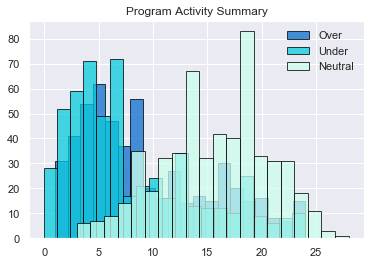

In [54]:
calculatePrActivityStats(program_activity_disease)

### All Program Activity Stats

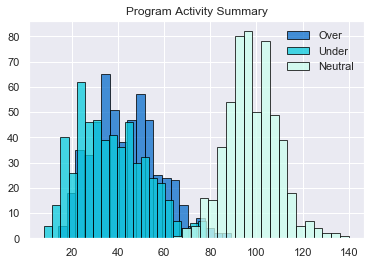

In [55]:
calculatePrActivityStats(program_activity_all)

### Disease relevant program activity heatmap

Text(181.05629139072846, 0.5, 'Programs')

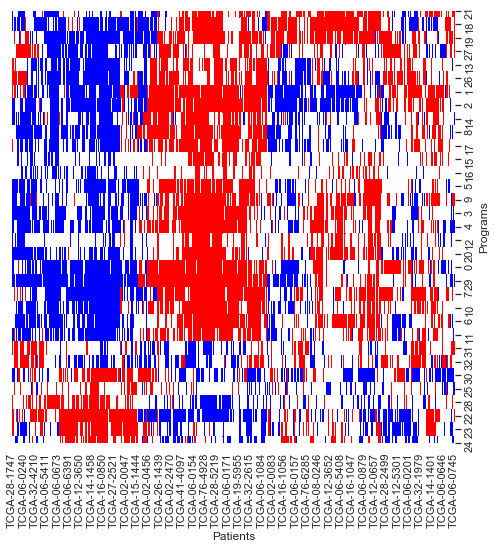

In [57]:
import seaborn as sns; sns.set()

g = sns.clustermap(program_activity_disease,row_cluster=True,col_cluster=True,cmap="bwr",vmin=-1,vmax=1)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
ax = g.ax_heatmap
ax.set_xlabel('Patients')
ax.set_ylabel('Programs')


### All program activity heatmap

Text(181.05629139072846, 0.5, 'Programs')

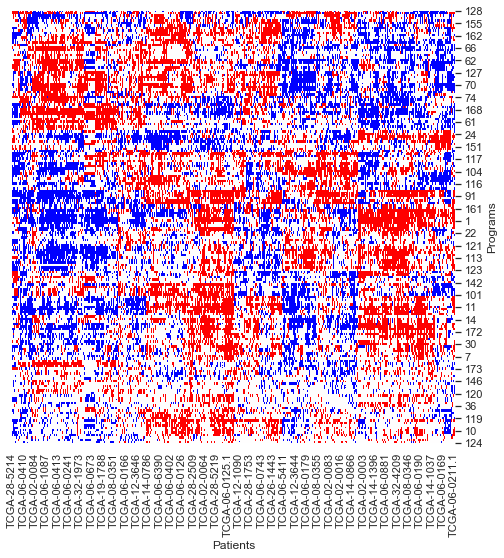

In [58]:
g = sns.clustermap(program_activity_all,row_cluster=True,col_cluster=True,cmap="bwr",vmin=-1,vmax=1)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
ax = g.ax_heatmap
ax.set_xlabel('Patients')
ax.set_ylabel('Programs')

## Program survival analysis

### Load primary survival data

In [59]:
# load primary survival data (i.e., corresponding to expression data training set)
survival_data = pd.read_csv(os.path.join(data_path,"TCGA_Survival_Gbm.csv"),index_col=0,header=0)
survival_data = survival_data.iloc[:,0:2]
survival_data.columns = ["duration","observed"]
survival_data.head()

#overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDf = miner.kmAnalysis(survivalDf=survival_data,durationCol="duration",statusCol="observed")
guanSurvivalDf= miner.guanRank(kmSurvival=kmDf)
guanSurvivalDf.head()
#guanSurvivalDfMMRF.to_csv("guanSurvivalDf_TCGA_GBM.csv")

,duration,observed,kmEstimate,GuanScore
Patient_ID,,,,
TCGA-12-0657,3,1,0.998062,1.000000
TCGA-19-2624,5,1,0.996113,0.998047
TCGA-41-4097,6,1,0.992214,0.995111
TCGA-06-0140,6,1,0.992214,0.995111
TCGA-06-0402,8,1,0.990261,0.992184


In [116]:
reload(miner)

<module 'miner_py3_kk' from '/Users/sturkars/github/GbmMINER/miner_py3_kk.py'>

### Function for survival analysis

In [63]:
def survivalAnalysis(disease_relevant=True):
    if disease_relevant == True:
        # load regulons
        regulonModules = loadRegulons(disease_relevant=True)
        print()
        # load programs
        program_list = loadPrograms(disease_relevant=True)
        print()
        # change plot title
        plt_title = "Program Risk Stratification for Disease Relevant Programs"
        
    else:
        # load regulons
        regulonModules = loadRegulons(disease_relevant=False)
        print()
        # load programs
        program_list = loadPrograms(disease_relevant=False)
        print()
        # change plot title
        plt_title = "Program Risk Stratification for All Programs"

        
    
    # Cox proportional hazards regression of transcriptional programs
    t1 = time.time()

    # Get program genes
    pr_genes_expanded = createPrGenesDictionary(program_list,regulonModules)

    #
    cox_programs_output = miner.parallelMedianSurvivalAnalysis(pr_genes_expanded,expressionData,guanSurvivalDf,numCores=5)
    cox_programs_output = cox_programs_output.iloc[np.argsort(np.array(cox_programs_output.index).astype(int))]
    #cox_programs_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsProgramsSig.csv'))
    cox_programs_output.sort_values(by="HR",ascending=False,inplace=True)

    print("\nHigh-risk programs:")
    print(cox_programs_output.iloc[0:5,:])
    print("\nLow-risk programs")
    print(cox_programs_output.iloc[-5:,:])

    t2 = time.time()
    print(t2-t1)

    # Kaplan-Meier plot of all programs (median expression)
    srv = guanSurvivalDf.copy()
    keys = list(pr_genes_expanded.keys())

    plt.figure(figsize=(8,8))
    plt.style.use('seaborn-whitegrid')
    plt.xlim(-100,2000)

    for key in keys:
        cluster = np.array(expressionData.loc[pr_genes_expanded[key],:])
        median_ = np.mean(cluster,axis=0)
        threshold = np.percentile(median_,85)
        median_[median_>=threshold] = 1
        median_[median_<threshold] = 0
        membership_df = pd.DataFrame(median_)
        membership_df.index = expressionData.columns
        membership_df.columns = [key]

        cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDf)

        groups = [membership_df.index[np.where(membership_df[key]==1)[0]]]
        labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
        miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                     filename=None,lw=2,color="gray",alpha=0.3)  


    key_min = cox_programs_output.index[0]
    key_max = cox_programs_output.index[-1]

    cluster = np.array(expressionData.loc[pr_genes_expanded[key_min],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key_min]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDf)

    groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="red",alpha=1)  


    cluster = np.array(expressionData.loc[pr_genes_expanded[key_max],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key_max]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDf)

    groups = [membership_df.index[np.where(membership_df[key_max]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="blue",alpha=1) 
    plt.ylabel('Survival probability')
    plt.xlabel('Time (days)')
    plt.title(plt_title)
    #plt.savefig(os.path.join(resultsDirectory,"kmplots_programsSig.pdf"),bbox_inches="tight")

### Survival analysis for Disease relevant programs

Total number of regulons: 3764
Filtered number of regulons: 505
Returned 505 filtered regulons

Total # of programs:  178
Filtered # of programs:  33
Returned 33 filtered Programs

Total number of genes: 1862
Completed 0 of 6 iterations
Completed 0 of 6 iterations
Completed 0 of 7 iterations
Completed 0 of 7 iterations
Completed 0 of 7 iterations

High-risk programs:
          HR   p-value
5   4.189558  0.000028
16  3.387876  0.000704
10  3.352874  0.000800
3   3.346766  0.000818
6   3.317328  0.000909

Low-risk programs
          HR   p-value
28 -2.156052  0.031080
22 -2.669248  0.007602
24 -2.688873  0.007169
25 -3.048244  0.002302
30 -3.277034  0.001049
1.4223859310150146


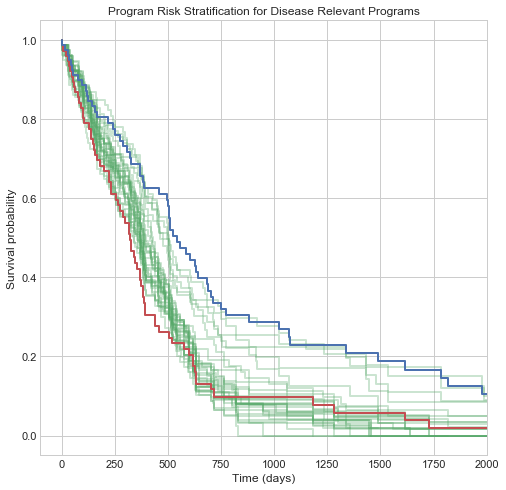

In [64]:
survivalAnalysis(disease_relevant=True)

### Survival analysis for All programs

Total number of regulons: 3764
Filtered number of regulons: 505
Returned 3764 Total regulons

Total # of programs:  178
Filtered # of programs:  33
Returned 178 Total Programs

Total number of genes: 1862
Completed 0 of 16 iterations
Completed 0 of 16 iterations
Completed 0 of 16 iterations
Completed 0 of 16 iterations
Completed 0 of 17 iterations

High-risk programs:
           HR   p-value
6    4.051721  0.000051
154  3.858160  0.000114
33   3.387876  0.000704
15   3.352874  0.000800
3    3.286085  0.001016

Low-risk programs
           HR   p-value
80  -3.207689  0.001338
153 -3.235994  0.001212
147 -3.426388  0.000612
75  -3.512248  0.000444
128 -3.753955  0.000174
2.4419400691986084


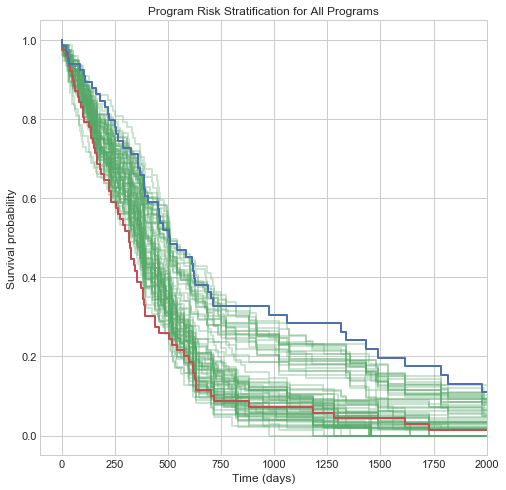

In [65]:
survivalAnalysis(disease_relevant=False)